Outcome Visualization

In [1]:
suf = "1211_212941"
suf_f = "1211_172527"
img_title = "HAM10000"
n_classes = 7

In [3]:
import numpy as np
import os
data_root = "C:/Users/20878/221Project/HAM10K/tmp/HAM10000"
# Load the .npy file
def bdnm(name, suf=suf):
    return name + suf + ".npy"

dict_batch = np.load(os.path.join(data_root, suf, bdnm("HAM10000_dict_batch_")), allow_pickle=True).reshape(1)[0]
dict_imgSize = np.load(os.path.join(data_root, suf, bdnm("HAM10000_dict_imgSize_")), allow_pickle=True).reshape(1)[0]

train_loss_list = np.load(os.path.join(data_root, suf, bdnm("HAM10000_train_loss_")))
train_loss_list_f = np.load(os.path.join(data_root, suf, bdnm("HAM10000_train_loss_", suf=suf_f)))
train_acc_list = np.load(os.path.join(data_root, suf, bdnm("HAM10000_train_acc_")))
train_acc_list_f = np.load(os.path.join(data_root, suf, bdnm("HAM10000_train_acc_", suf=suf_f)))
test_loss_list = np.load(os.path.join(data_root, suf, bdnm("HAM10000_test_loss_")))
test_acc_list = np.load(os.path.join(data_root, suf, bdnm("HAM10000_test_acc_")))
test_auc_list = np.load(os.path.join(data_root, suf, bdnm("HAM10000_test_auc_")))
val_loss_list = np.load(os.path.join(data_root, suf, bdnm("HAM10000_val_loss_")))
val_acc_list = np.load(os.path.join(data_root, suf, bdnm("HAM10000_val_acc_")))
val_acc_list_f = np.load(os.path.join(data_root, suf, bdnm("HAM10000_val_acc_", suf=suf_f)))            

In [4]:
import seaborn as sns

from utils import ImageShow,draw_size_acc,one_hot
from utils import confusion_matrix,metrics_scores,pff

In [10]:
show = ImageShow(train_loss_list = np.concatenate((train_loss_list_f, train_loss_list)),
                 train_acc_list = np.concatenate((train_acc_list_f, train_acc_list)),
                test_loss_list = test_loss_list,
                test_acc_list = test_acc_list,
                test_auc_list = test_auc_list,
                val_loss_list = val_loss_list,
                val_acc_list = np.concatenate((val_acc_list_f, val_acc_list)),
                )
# numpy.concatenate((a1, a2, ...), axis=0, out=None, dtype=None, casting="same_kind")

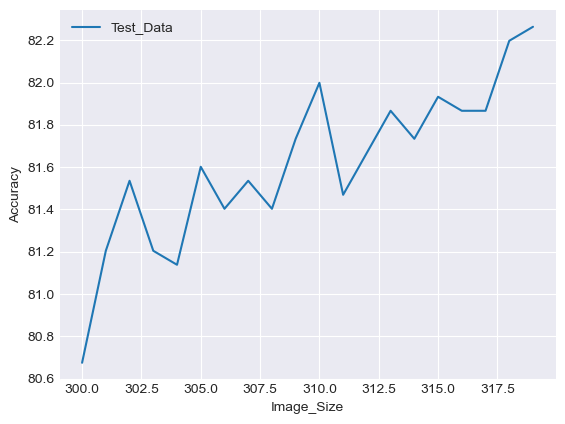

In [11]:
draw_size_acc(dict_imgSize,custom_path='./tmp',img_title=img_title,suf=suf)

In [12]:
import torch
test_evl_result = torch.load(os.path.join(data_root, suf, "best_test_evl_result.pth"))
val_evl_result = torch.load(os.path.join(data_root, suf, "best_evl_result.pth")) 
cla_dict = {0: 'akiec', 1: 'bcc', 2: 'bkl', 3: 'df', 4: 'mel', 5: 'nv', 6: 'vasc'}
metrics_scores(test_evl_result,n_classes,cla_dict)

+--------+-----------+--------+-------+----------+
|  Type  | Precision | Recall |   F1  | Accuracy |
+--------+-----------+--------+-------+----------+
| akiec  |   0.4286  | 0.279  | 0.338 |          |
|  bcc   |   0.664   | 0.892  | 0.761 |          |
|  bkl   |   0.6727  | 0.862  | 0.756 |          |
|   df   |   0.4667  | 0.318  | 0.378 |          |
|  mel   |   0.9041  | 0.386  | 0.541 |          |
|   nv   |   0.9018  |  0.96  |  0.93 |          |
|  vasc  |    0.9    | 0.257  |  0.4  |          |
| Total: |           |        |       |  0.8226  |
+--------+-----------+--------+-------+----------+


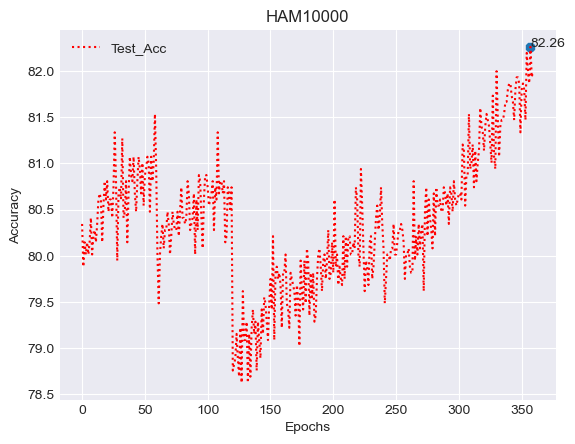

In [13]:
show.test(write=True,custom_path='./tmp',img_title=img_title,suf=suf)

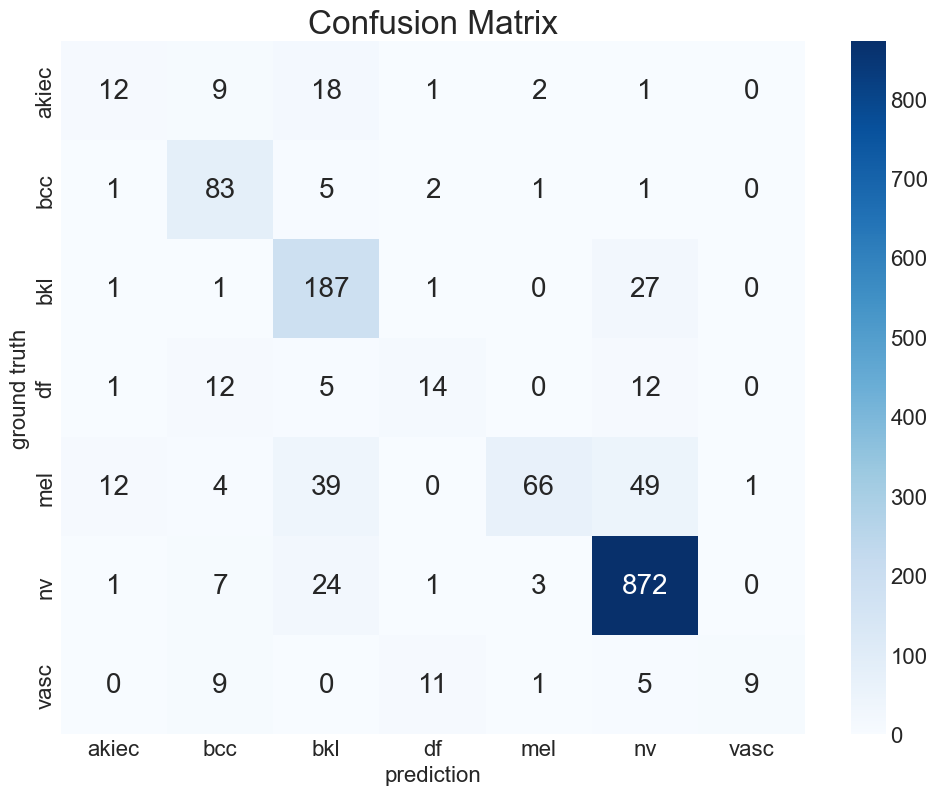

In [14]:
confusion_matrix(test_evl_result,n_classes,cla_dict,kn="test",img_title=img_title,suf=suf)

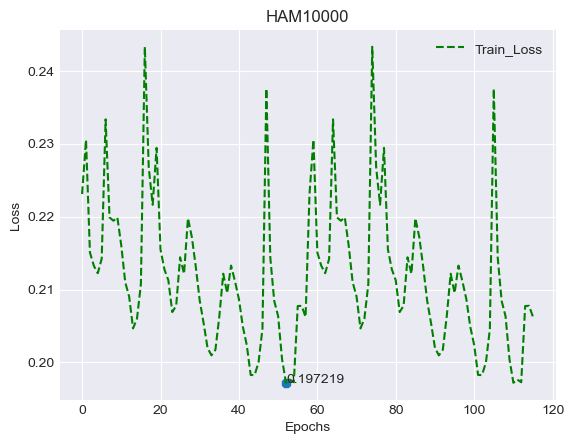

In [15]:
show.train(write=True,custom_path='./tmp',img_title=img_title,suf=suf)

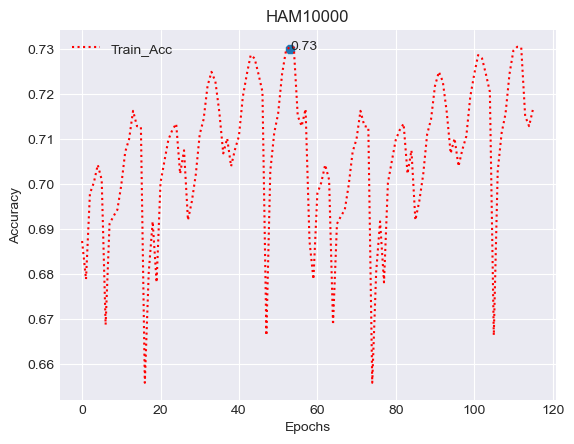

In [16]:
show.train(opt='Acc',write=True,custom_path='./tmp',img_title=img_title,suf=suf)

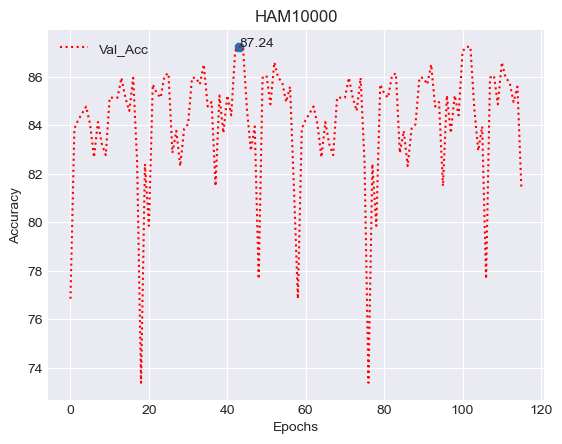

In [17]:
show.val(write=True,custom_path='./tmp',img_title=img_title,suf=suf)

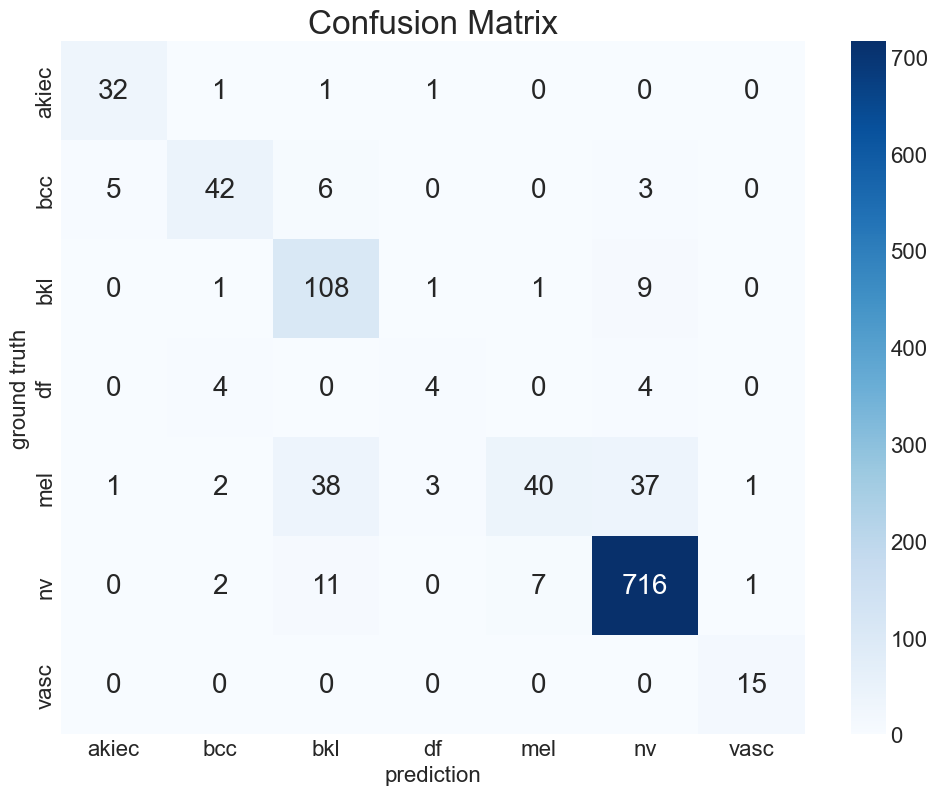

In [18]:
confusion_matrix(val_evl_result,n_classes,cla_dict,kn="val",img_title=img_title,suf=suf)

Preparation for Conformal Prediction:
Softmax Score Calculation on the Test Set

In [20]:
import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np

In [21]:
# Define dataset and transformations
data_dir = "C:/Users/20878/221Project/HAM10K/test_dir"
trans_test = 311
transform = transforms.Compose([transforms.Resize((trans_test,trans_test)),
                                   transforms.CenterCrop((299, 299)),
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                  ])

dataset = datasets.ImageFolder(root=data_dir, transform=transform)

In [22]:
# Create DataLoader
dataloader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=2)

In [25]:
# Load the model
from model import FixCapsNet
# Create capsule network.
n_channels = 3
conv_outputs = 128 #Feature_map
num_primary_units = 8
primary_unit_size = 16 * 6 * 6  # fixme get from conv2d
output_unit_size = 16
img_size = 299
mode='128'
model = FixCapsNet(conv_inputs=n_channels,
                     conv_outputs=conv_outputs,
                     primary_units=num_primary_units,
                     primary_unit_size=primary_unit_size,
                     num_classes=n_classes,
                     output_unit_size=16,
                     init_weights=True,
                     mode=mode)
model = model.to("cpu")

md_name = "best_test_HAM10000_"+ suf+ ".pth"
state_dict = torch.load(os.path.join(data_root, suf, md_name), map_location=torch.device('cpu'))
model.load_state_dict(state_dict)
model.eval() 

FixCapsNet(
  (Convolution): Sequential(
    (0): Conv2d(3, 128, kernel_size=(18, 18), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): FractionalMaxPool2d()
  )
  (CBAM): Conv_CBAM(
    (conv): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act): Hardswish()
    (ca): ChannelAttention(
      (avg_pool): AdaptiveAvgPool2d(output_size=1)
      (max_pool): AdaptiveMaxPool2d(output_size=1)
      (fc1): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (relu1): ReLU(inplace=True)
      (fc2): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (sigmoid): Sigmoid()
    )
    (sa): SpatialAttention(
      (conv1): Conv2d(2, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (sigmoid): Sigmoid()
    )
  )
  (primary): Primary_Caps(
    (Caps_0): ConvUnit(
      (Cpas): Sequential(
        (0): Conv2d(128, 16, kernel_size

In [26]:
# Compute softmax outputs and collect labels
softmax_outputs = []
labels = []

with torch.no_grad():
    for images, label in dataloader:
        outputs = model(images)
        result = torch.sqrt(torch.sum(outputs**2, dim=2, keepdim=True))
        result_squeezed = result.squeeze(-1).squeeze(-1)
        softmax_probs = torch.softmax(result_squeezed, dim=1)
        softmax_outputs.append(softmax_probs.cpu().numpy())
        labels.append(label.numpy())

In [27]:
# Convert lists to matrices
softmax_matrix = np.vstack(softmax_outputs)
label_vector = np.concatenate(labels)
np.save(f"{data_root}/{suf}/cp_softmax_outputs.npy", softmax_matrix)
np.save(f"{data_root}/{suf}/cp_labels.npy", label_vector)

print(f"Softmax outputs shape: {softmax_matrix.shape}")
print(f"Labels shape: {label_vector.shape}")

Softmax outputs shape: (1511, 7)
Labels shape: (1511,)


Adaptive Conformal Prediction

In [28]:
suf = "1211_212941"
img_title = "HAM10000"
n_classes = 7
data_root = "C:/Users/20878/221Project/HAM10K/tmp/HAM10000"

In [29]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns

In [30]:
# Load the .npy file
smx = np.load(os.path.join(data_root, suf, "cp_softmax_outputs.npy"))
labels = np.load(os.path.join(data_root, suf, "cp_labels.npy"))

In [31]:
# Problem setup
n = 1000  # number of calibration points
alpha = 0.1  # 1-alpha is the desired coverage

In [32]:
# Split the softmax scores into calibration and validation sets (save the shuffling)
idx = np.array([1] * n + [0] * (smx.shape[0] - n)) > 0
np.random.shuffle(idx)
cal_smx, val_smx = smx[idx, :], smx[~idx, :]
cal_labels, val_labels = labels[idx], labels[~idx]

In [33]:
# Get scores. calib_X.shape[0] == calib_Y.shape[0] == n
cal_pi = cal_smx.argsort(1)[:, ::-1]
cal_srt = np.take_along_axis(cal_smx, cal_pi, axis=1).cumsum(axis=1)
cal_scores = np.take_along_axis(cal_srt, cal_pi.argsort(axis=1), axis=1)[
    range(n), cal_labels
]
# Get the score quantile
qhat = np.quantile(
    cal_scores, np.ceil((n + 1) * (1 - alpha)) / n, interpolation="higher"
)
# Deploy (output=list of length n, each element is tensor of classes)
val_pi = val_smx.argsort(1)[:, ::-1]
val_srt = np.take_along_axis(val_smx, val_pi, axis=1).cumsum(axis=1)
prediction_sets = np.take_along_axis(val_srt <= qhat, val_pi.argsort(axis=1), axis=1)

In [34]:
#Calculate empirical coverage
empirical_coverage = prediction_sets[
    np.arange(prediction_sets.shape[0]), val_labels
].mean()
print(f"The empirical coverage is: {empirical_coverage}")

The empirical coverage is: 0.8864970645792564


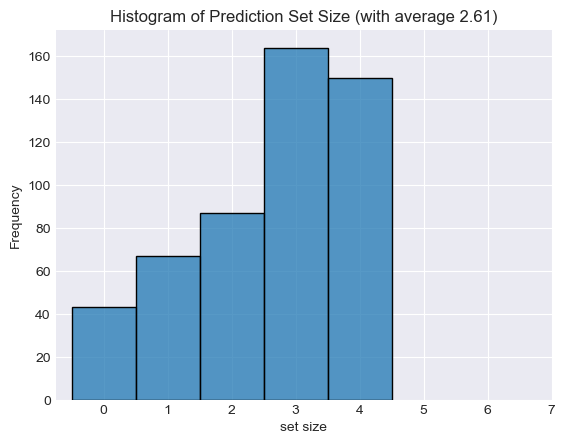

In [35]:
set_size = np.sum(prediction_sets, axis=1)
sns.histplot(set_size, discrete=True)
plt.title("Histogram of Prediction Set Size "+
f"(with average {np.round(set_size.mean(), 2)})")
plt.xlabel("set size")
plt.gca().set_xticks(np.arange(0, 8, 1))
plt.ylabel("Frequency")
plt.show()

In [36]:
# feature-stratified coverage metric
idx = {"0":[], "1":[], "2":[]}
n_val = val_smx.shape[0]
idx["0"] = np.arange(n_val)[np.sum(prediction_sets, axis=1) == 1]
idx["1"] = np.arange(n_val)[np.sum(prediction_sets, axis=1) == 2]
idx["2"] = np.arange(n_val)[np.sum(prediction_sets, axis=1) > 2]
ssc = np.inf
for i in range(3):
    tmp = prediction_sets[idx[f"{i}"], val_labels[idx[f"{i}"]]].mean()
    if tmp < ssc: ssc = tmp
print(ssc)

0.9540229885057471


Regularized Adaptive Conformal Prediction: parameters tuning (run in the local env:sklearn)

In [1]:
suf = "1211_212941"
img_title = "HAM10000"
n_classes = 7
data_root = "C:/Users/20878/221Project/HAM10K/tmp/HAM10000"

In [2]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
from sklearn.model_selection import KFold

In [3]:
# Load the .npy file
smx = np.load(os.path.join(data_root, suf, "cp_softmax_outputs.npy"))
labels = np.load(os.path.join(data_root, suf, "cp_labels.npy"))

In [4]:
# Set hyperparameters
alpha = 0.1  # Desired coverage
n_splits = 10  # Number of folds for cross-validation
lambda_grid = [1e-8, 5e-8, 1e-7, 5e-7, 1e-6, 5e-6, 1e-5, 5e-5, 1e-4, 5e-4, 0.001, 0.005, 0.01, 0.05]  # Values to test for lam_reg
k_grid = [1, 2, 3]  # Values to test for k_reg

# Split the softmax scores into calibration and validation sets (save the shuffling)
n = 1112  # Number of calibration points
idx = np.array([1] * n + [0] * (smx.shape[0]-n)) > 0
np.random.shuffle(idx)
cal_smx, val_smx = smx[idx,:], smx[~idx,:]
cal_labels, val_labels = labels[idx], labels[~idx]

# Define helper function to compute prediction sets
def compute_prediction_sets(cal_smx, cal_labels, val_smx, val_labels, lam_reg, k_reg, 
                           disallow_zero_sets=False):
    
    num_classes = cal_smx.shape[1]
    reg_vec = np.array(k_reg * [0,] + (num_classes - k_reg) * [lam_reg,])[None, :]
    
    # Sort scores and apply regularization
    n_cal = cal_smx.shape[0]
    cal_pi = cal_smx.argsort(1)[:, ::-1]
    cal_srt = np.take_along_axis(cal_smx, cal_pi, axis=1)
    cal_srt_reg = cal_srt + reg_vec
    cal_L = np.where(cal_pi == cal_labels[:, None])[1]
    cal_scores = cal_srt_reg.cumsum(axis=1)[np.arange(n_cal),cal_L] - np.random.rand(n_cal)*cal_srt_reg[np.arange(n_cal),cal_L]

    # Compute quantile
    qhat = np.quantile(cal_scores, np.ceil((n_cal + 1) * (1 - alpha)) / n_cal, interpolation="higher")
    
    # Compute prediction sets
    n_val = val_smx.shape[0]
    val_pi = val_smx.argsort(1)[:,::-1]
    val_srt = np.take_along_axis(val_smx,val_pi,axis=1)
    val_srt_reg = val_srt + reg_vec
    val_srt_reg_cumsum = val_srt_reg.cumsum(axis=1)
    indicators = (val_srt_reg.cumsum(axis=1) - np.random.rand(n_val,1)*val_srt_reg) <= qhat
    if disallow_zero_sets: indicators[:,0] = True
    prediction_sets_size = indicators.sum(axis=1)  # Size of the prediction set per instance
    prediction_sets = np.take_along_axis(indicators,val_pi.argsort(axis=1),axis=1)
    empirical_coverage = prediction_sets[np.arange(n_val), val_labels].mean()
    return prediction_sets, prediction_sets_size, empirical_coverage

In [5]:
# Cross-validation
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
results = []

for lam_reg in lambda_grid:
    for k_reg in k_grid:
        fold_coverages = []
        fold_set_sizes = []
        
        for train_idx, cvval_idx in kf.split(cal_smx):
            train_smx, cvval_smx = cal_smx[train_idx], cal_smx[cvval_idx]
            train_labels, cvval_labels = cal_labels[train_idx], cal_labels[cvval_idx]
            
            # Compute prediction sets and empirical coverage
            prediction_sets, prediction_sets_size, empirical_coverage = \
            compute_prediction_sets(train_smx, train_labels, cvval_smx, cvval_labels, lam_reg, k_reg)
            
            fold_coverages.append(empirical_coverage)

            # Compute average set size
            average_set_size = np.mean(prediction_sets_size)
            fold_set_sizes.append(average_set_size)
        
        # Store results
        avg_coverage = np.mean(fold_coverages)
        avg_set_size = np.mean(fold_set_sizes)
        results.append({
            "lam_reg": lam_reg,
            "k_reg": k_reg,
            "coverage": avg_coverage,
            "set_size": avg_set_size
        })

# Select optimal parameters
valid_results = [res for res in results if res["coverage"]-1+alpha >= -0.25]
optimal_params = min(valid_results, key=lambda x: x["set_size"]) if valid_results else None

if optimal_params:
    print(f"Optimal parameters: lam_reg={optimal_params['lam_reg']}, k_reg={optimal_params['k_reg']}")
    print(f"Coverage: {optimal_params['coverage']}, Average set size: {optimal_params['set_size']}")
else:
    print("No valid parameters found that meet the desired coverage.")

C:\Users\20878\AppData\Local\Temp\ipykernel_17008\4214744965.py:30: DeprecationWarning: the `interpolation=` argument to quantile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  qhat = np.quantile(cal_scores, np.ceil((n_cal + 1) * (1 - alpha)) / n_cal, interpolation="higher")


Optimal parameters: lam_reg=0.05, k_reg=1
Coverage: 0.9010537323037322, Average set size: 1.825466537966538


RAPS

In [6]:
# Problem setup
n=1112 # number of calibration points
alpha = 0.1 # 1-alpha is the desired coverage
# Set RAPS regularization parameters (larger lam_reg and smaller k_reg leads to smaller sets)
lam_reg = 0.05  # HOW TO DETERMINE?
k_reg = 1  # HOW TO DETERMINE?
disallow_zero_sets = True # Set this to False in order to see the coverage upper bound hold
rand = True # Set this to True in order to see the coverage upper bound hold
reg_vec = np.array(k_reg*[0,] + (smx.shape[1]-k_reg)*[lam_reg,])[None,:]

In [7]:
idx = np.array([1] * n + [0] * (smx.shape[0]-n)) > 0
np.random.shuffle(idx)
cal_smx, val_smx = smx[idx,:], smx[~idx,:]
cal_labels, val_labels = labels[idx], labels[~idx]

In [8]:
# Get scores. calib_X.shape[0] == calib_Y.shape[0] == n
cal_pi = cal_smx.argsort(1)[:,::-1]; 
cal_srt = np.take_along_axis(cal_smx,cal_pi,axis=1)
cal_srt_reg = cal_srt + reg_vec
cal_L = np.where(cal_pi == cal_labels[:,None])[1]
cal_scores = cal_srt_reg.cumsum(axis=1)[np.arange(n),cal_L] - np.random.rand(n)*cal_srt_reg[np.arange(n),cal_L]
# Get the score quantile
qhat = np.quantile(cal_scores, np.ceil((n+1)*(1-alpha))/n, interpolation='higher')
# Deploy
n_val = val_smx.shape[0]
val_pi = val_smx.argsort(1)[:,::-1]
val_srt = np.take_along_axis(val_smx,val_pi,axis=1)
val_srt_reg = val_srt + reg_vec
val_srt_reg_cumsum = val_srt_reg.cumsum(axis=1)
indicators = (val_srt_reg.cumsum(axis=1) - np.random.rand(n_val,1)*val_srt_reg) <= qhat if rand else val_srt_reg.cumsum(axis=1) - val_srt_reg <= qhat
if disallow_zero_sets: indicators[:,0] = True
prediction_sets = np.take_along_axis(indicators,val_pi.argsort(axis=1),axis=1)

C:\Users\20878\AppData\Local\Temp\ipykernel_17008\602926285.py:8: DeprecationWarning: the `interpolation=` argument to quantile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  qhat = np.quantile(cal_scores, np.ceil((n+1)*(1-alpha))/n, interpolation='higher')


In [9]:
# Calculate empirical coverage
empirical_coverage = prediction_sets[np.arange(n_val),val_labels].mean()
print(f"The empirical coverage is: {empirical_coverage}")
print(f"The quantile is: {qhat}")

The empirical coverage is: 0.9423558897243107
The quantile is: 0.6097878285644568


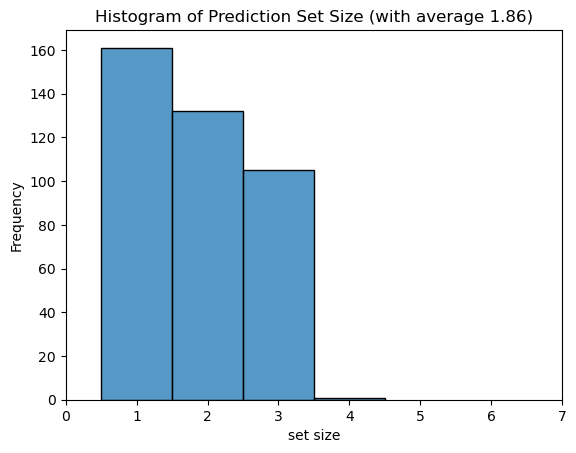

In [10]:
set_size = np.sum(prediction_sets, axis=1)
sns.histplot(set_size, discrete=True)
plt.title("Histogram of Prediction Set Size "+
f"(with average {np.round(set_size.mean(), 2)})")
plt.xlabel("set size")
plt.gca().set_xticks(np.arange(0, 8, 1))
plt.ylabel("Frequency")
plt.show()

In [11]:
# feature-stratified coverage metric
idx = {"0":[], "1":[], "2":[]}
idx["0"] = np.arange(n_val)[np.sum(prediction_sets, axis=1) == 1]
idx["1"] = np.arange(n_val)[np.sum(prediction_sets, axis=1) == 2]
idx["2"] = np.arange(n_val)[np.sum(prediction_sets, axis=1) > 2]
ssc = np.inf
for i in range(3):
    tmp = prediction_sets[idx[f"{i}"], val_labels[idx[f"{i}"]]].mean()
    if tmp < ssc: ssc = tmp
print(ssc)

0.9242424242424242


prepare for correctness checks: get RAPS scores

In [12]:
suf = "1211_212941"
img_title = "HAM10000"
n_classes = 7
data_root = "C:/Users/20878/221Project/HAM10K/tmp/HAM10000"

In [13]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns

In [14]:
# Load the .npy file
smx = np.load(os.path.join(data_root, suf, "cp_softmax_outputs.npy"))
labels = np.load(os.path.join(data_root, suf, "cp_labels.npy"))

In [15]:
# Set up
lam_reg = 0.05
k_reg = 1
reg_vec = np.array(k_reg*[0,] + (smx.shape[1]-k_reg)*[lam_reg,])[None,:]

In [16]:
# Get scores. 
N = smx.shape[0]
pi = smx.argsort(1)[:,::-1]; 
srt = np.take_along_axis(smx,pi,axis=1).cumsum(axis=1)
srt_reg = srt + reg_vec
L = np.where(pi == labels[:,None])[1]
scores = srt_reg.cumsum(axis=1)[np.arange(N),L] - srt_reg[np.arange(N),L]
np.save(f"{data_root}/{suf}/cp_raps_scores.npy",scores)

correctness checks:

In [17]:
suf = "1211_212941"
img_title = "HAM10000"
n_classes = 7
data_root = "C:/Users/20878/221Project/HAM10K/tmp/HAM10000"

In [18]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns

In [19]:
# Load the .npy file
scores = np.load(os.path.join(data_root, suf, "cp_raps_scores.npy"))

In [20]:
# Set up
R = 1000
alpha = 0.1
n = 1112

C:\Users\20878\AppData\Local\Temp\ipykernel_17008\3915770802.py:6: DeprecationWarning: the `interpolation=` argument to quantile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  qhat = np.quantile(calib_scores, np.ceil((n+1)*(1-alpha))/n, interpolation='higher') # calibrate


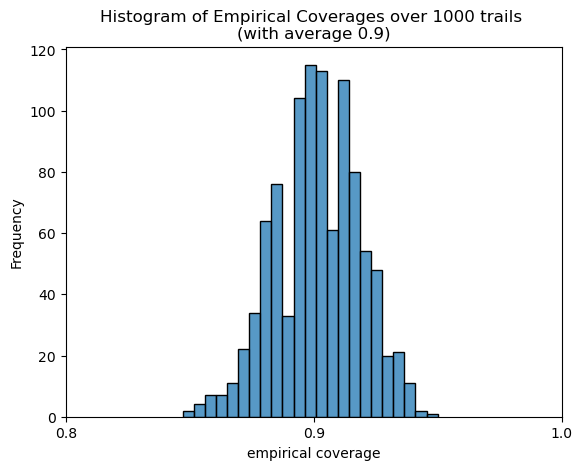

In [21]:
# calculate the coverage R times and store in list
coverages = np.zeros((R,))
for r in range(R):
    np.random.shuffle(scores) # shuffle
    calib_scores, val_scores= (scores[:n],scores[n:]) # split
    qhat = np.quantile(calib_scores, np.ceil((n+1)*(1-alpha))/n, interpolation='higher') # calibrate
    coverages[r] = (val_scores <= qhat).astype(float).mean() # see caption
average_coverage = coverages.mean() # should be close to 1-alpha

sns.histplot(coverages)
plt.title(f"Histogram of Empirical Coverages over {R} trails \n(with average {np.round(average_coverage, 2)})")
plt.xlabel("empirical coverage")
plt.gca().set_xticks(np.arange(0.8, 1.09, .1))
plt.ylabel("Frequency")
plt.show()